__mlmachine - Part 5: Hyperparameter Tuning with Bayesian Optimization__

1. [Bayesian Optimization for Multiple Estimators in One Shot](#Bayesian-Optimization-for-Multiple-Estimators-in-One-Shot)
1. [Results Analysis](#Results-Analysis)
1. [Model Reinstantiation](#Model-Reinstantiation)

In [1]:
# standard libary and settings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder
from hyperopt import hp
from xgboost import XGBClassifier
import mlmachine as mlm
from mlmachine.data import titanic
from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
    GroupbyImputer,
    KFoldEncoder,
    DualTransformer,
)

c:\users\petersont\appdata\local\continuum\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Bayesian Optimization for Multiple Estimators in One Shot

<a id = 'Bayesian-Optimization-for-Multiple-Estimators-in-One-Shot'></a>

# Results Analysis

<a id = 'Results-Analysis'></a>

# Model-Reinstantiation

<a id = 'Model-Reinstantiation'></a>

In [2]:
df_train, df_valid = titanic()

ordinal_encodings = {"Pclass": [1, 2, 3]}

mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

### impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked"])
    )),
])

mlmachine_titanic_train.data = impute_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = impute_pipe.transform(mlmachine_titanic_valid.data)

# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

mlmachine_titanic_train.data = polynomial_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = polynomial_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### encode & bin pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

mlmachine_titanic_train.data = encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = encode_pipe.fit_transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### impute pipeline
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]), 
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

mlmachine_titanic_train.data = target_encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = target_encode_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### scale values
scale = PandasTransformer(RobustScaler())

mlmachine_titanic_train.data = scale.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = scale.transform(mlmachine_titanic_valid.data)

>>> category label encoding

	0 --> 0
	1 --> 1



Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [3]:
mlmachine_titanic_train.data

,Age,Age*Fare,Age*Fare_binned_5,Age*Fare_binned_5_catboost_encoded,Age*Fare_binned_5_target_encoded,Age*Fare_binned_5_woe_encoded,Age^2,Age^2_binned_5,Age^2_binned_5_catboost_encoded,Age^2_binned_5_target_encoded,...,Parch,Pclass_ordinal_encoded,Pclass_ordinal_encoded_catboost_encoded,Pclass_ordinal_encoded_target_encoded,Pclass_ordinal_encoded_woe_encoded,Sex_male,Sex_male_catboost_encoded,Sex_male_target_encoded,Sex_male_woe_encoded,SibSp
0,-0.622287,-0.241862,-1.0,-0.061922,0.257553,-0.090433,-0.568680,-0.5,0.196885,0.754887,...,0.0,0.0,-0.089623,0.000000,-0.167183,0.0,0.017268,0.017703,0.000604,1.0
1,0.608483,2.880011,1.0,1.746016,1.330575,1.479878,0.726867,1.0,0.660192,0.000000,...,0.0,-2.0,1.760707,1.370847,1.550231,-1.0,0.996585,0.989747,0.991390,1.0
2,-0.314594,-0.184856,-0.5,-1.034485,-0.868374,-1.118681,-0.309570,-0.5,0.196885,-0.053122,...,0.0,0.0,-0.089623,-0.121216,-0.167183,-1.0,0.996585,0.991811,0.991390,0.0
3,0.377713,1.838762,1.0,1.746016,1.529026,1.479878,0.431320,0.5,-0.550145,-0.358207,...,0.0,-2.0,1.760707,1.518257,1.550231,-1.0,0.996585,1.018386,0.991390,1.0
4,0.377713,-0.092152,0.0,-0.528664,-0.424139,-0.541412,0.431320,0.5,-0.550145,-0.164268,...,0.0,0.0,-0.089623,-0.092714,-0.167183,0.0,0.017268,-0.004054,0.000604,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.237671,-0.007348,0.0,-0.328148,-0.392308,-0.307120,-0.238045,-0.5,0.037256,-0.053122,...,0.0,-1.0,0.976021,0.788897,0.876603,0.0,0.000000,-0.013572,-0.013136,0.0
887,-0.853056,0.260843,0.5,0.447477,0.390087,0.391274,-0.734672,-1.0,1.386391,2.241119,...,0.0,-2.0,1.488058,1.370847,1.319121,-1.0,0.982567,0.989747,0.985342,0.0
888,0.000000,0.426906,0.5,0.447477,0.607692,0.391274,0.000000,0.0,0.584119,0.775099,...,2.0,0.0,0.000000,0.000000,-0.040700,-1.0,0.982567,1.018386,0.985342,1.0
889,-0.314594,0.518013,0.5,0.447477,0.576066,0.391274,-0.309570,-0.5,0.037256,-0.053122,...,0.0,-2.0,1.488058,1.549093,1.319121,0.0,0.000000,-0.013572,-0.013136,0.0


In [4]:
estimators = [
    LogisticRegression,
    XGBClassifier,
    RandomForestClassifier,
    KNeighborsClassifier,
]

fs = mlmachine_titanic_train.FeatureSelector(
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    estimators=estimators,
)
# feature_selector_summary = fs.feature_selector_suite(
#     sequential_scoring="accuracy",
#     sequential_n_folds=0,
#     add_stats=True,
#     n_jobs=1,
#     save_to_csv=True,
# )
feature_selector_summary=pd.read_csv("feature_selection_summary.csv", index_col=0)   

In [5]:
# # calculate cross-validation performance
# cv_summary = fs.feature_selector_cross_val(
#     feature_selector_summary=feature_selector_summary,
#     estimators=estimators,
#     scoring=["accuracy"],
#     n_folds=5,
#     step=1,
#     n_jobs=4,
#     save_to_csv=True,
# )
cv_summary= pd.read_csv("cv_summary.csv", index_col=0)

In [6]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)

In [7]:
# model/parameter space
estimator_parameter_space = {
    "LogisticRegression": {
        "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
        "penalty": hp.choice("penalty", ["l2"]),
    },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "subsample": hp.uniform("subsample", 0.3, 1),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

# # execute bayesian optimization grid search
# mlmachine_titanic_train.exec_bayes_optim_search(
#     estimator_parameter_space=estimator_parameter_space,
#     data=mlmachine_titanic_train.data,
#     target=mlmachine_titanic_train.target,
#     columns=cross_val_feature_dict,
#     scoring="accuracy",
#     n_folds=5,
#     n_jobs=5,
#     iters=200,
#     show_progressbar=True,
# )

In [8]:
bayes_optim_summary = pd.read_csv("bayes_optimization_summary_accuracy.csv", na_values="nan")
bayes_optim_summary

,iteration,estimator,scoring,loss,mean_score,std_score,min_score,max_score,train_time,status,params
0,1,LogisticRegression,accuracy,0.204218,0.795782,0.026768,0.754190,0.825843,1.080047,ok,"{'C': 0.008174796663349533, 'penalty': 'l2', '..."
1,2,LogisticRegression,accuracy,0.210922,0.789078,0.037798,0.720670,0.820225,1.232385,ok,"{'C': 0.007456580176063114, 'penalty': 'l2', '..."
2,3,LogisticRegression,accuracy,0.196384,0.803616,0.027326,0.769663,0.848315,1.175930,ok,"{'C': 0.015197336097355196, 'penalty': 'l2', '..."
3,4,LogisticRegression,accuracy,0.191890,0.808110,0.025218,0.780899,0.842697,1.189311,ok,"{'C': 0.016970348333069277, 'penalty': 'l2', '..."
4,5,LogisticRegression,accuracy,0.196391,0.803609,0.014813,0.786517,0.825843,1.207008,ok,"{'C': 0.03346957219746275, 'penalty': 'l2', 'n..."
...,...,...,...,...,...,...,...,...,...,...,...
795,196,KNeighborsClassifier,accuracy,0.196366,0.803634,0.037666,0.752809,0.848315,1.195285,ok,"{'algorithm': 'auto', 'n_neighbors': 12, 'weig..."
796,197,KNeighborsClassifier,accuracy,0.188500,0.811500,0.039510,0.765363,0.870787,1.237776,ok,"{'algorithm': 'auto', 'n_neighbors': 9, 'weigh..."
797,198,KNeighborsClassifier,accuracy,0.191871,0.808129,0.037196,0.765363,0.865169,1.200201,ok,"{'algorithm': 'brute', 'n_neighbors': 10, 'wei..."
798,199,KNeighborsClassifier,accuracy,0.179562,0.820438,0.030073,0.769663,0.859551,1.213567,ok,"{'algorithm': 'auto', 'n_neighbors': 5, 'weigh..."


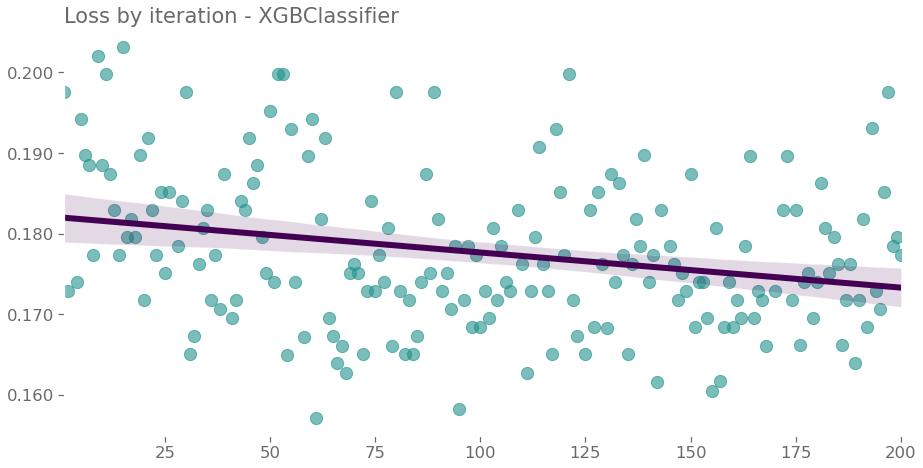

In [9]:
mlmachine_titanic_train.model_loss_plot(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class="XGBClassifier",
)

****************************************************************************************************
* KNeighborsClassifier
****************************************************************************************************


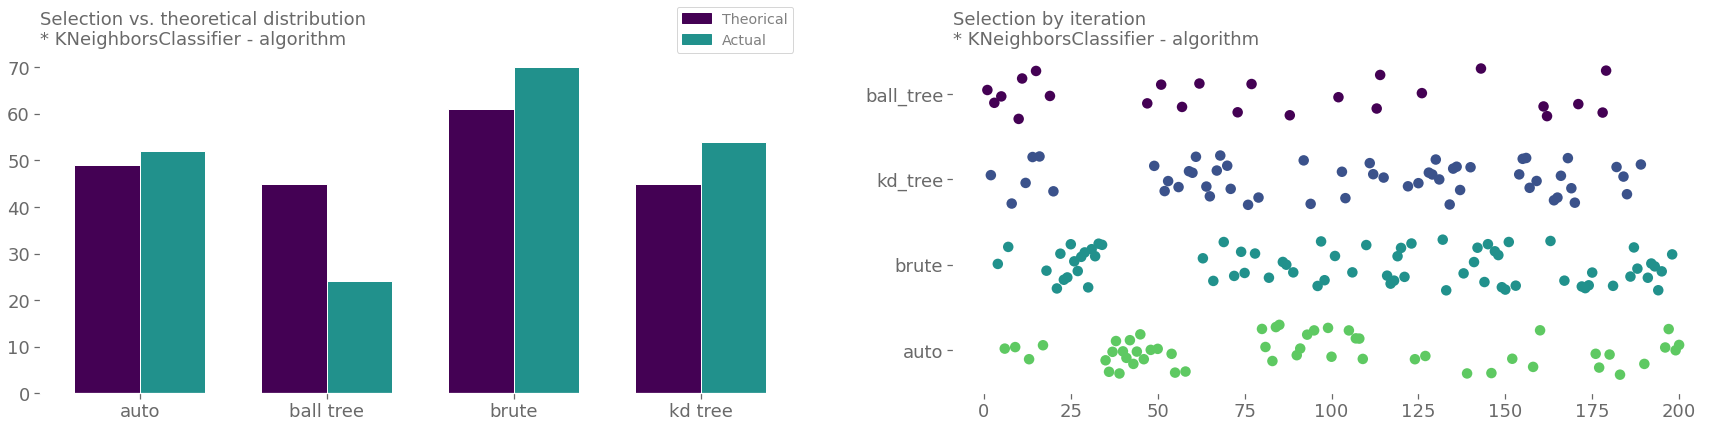

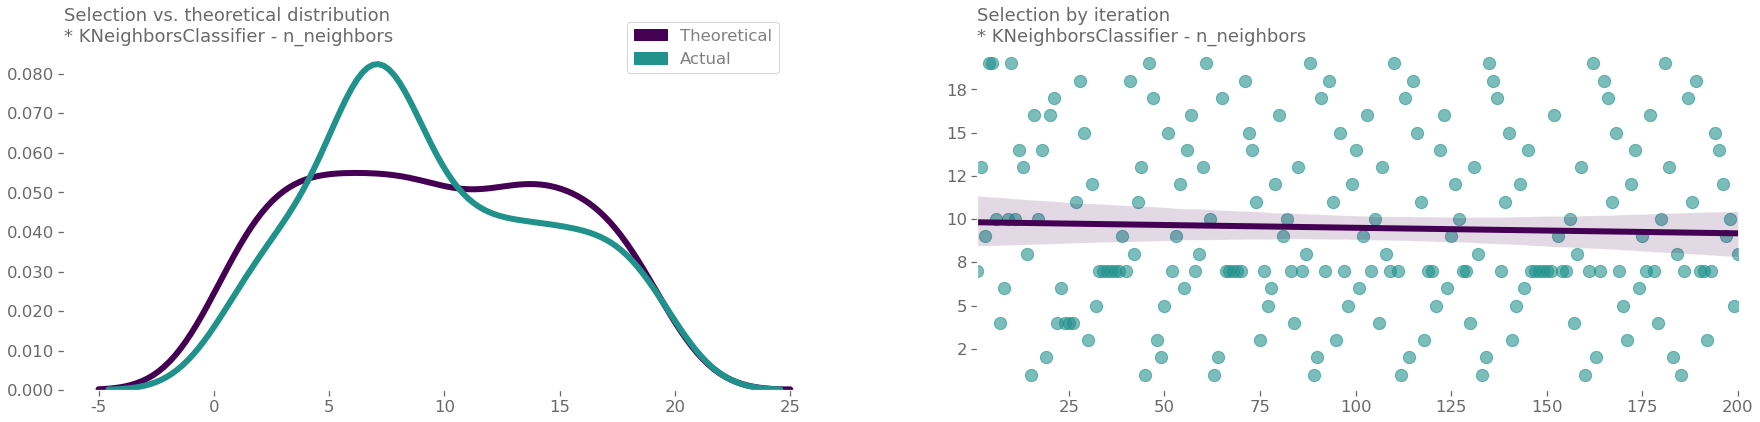

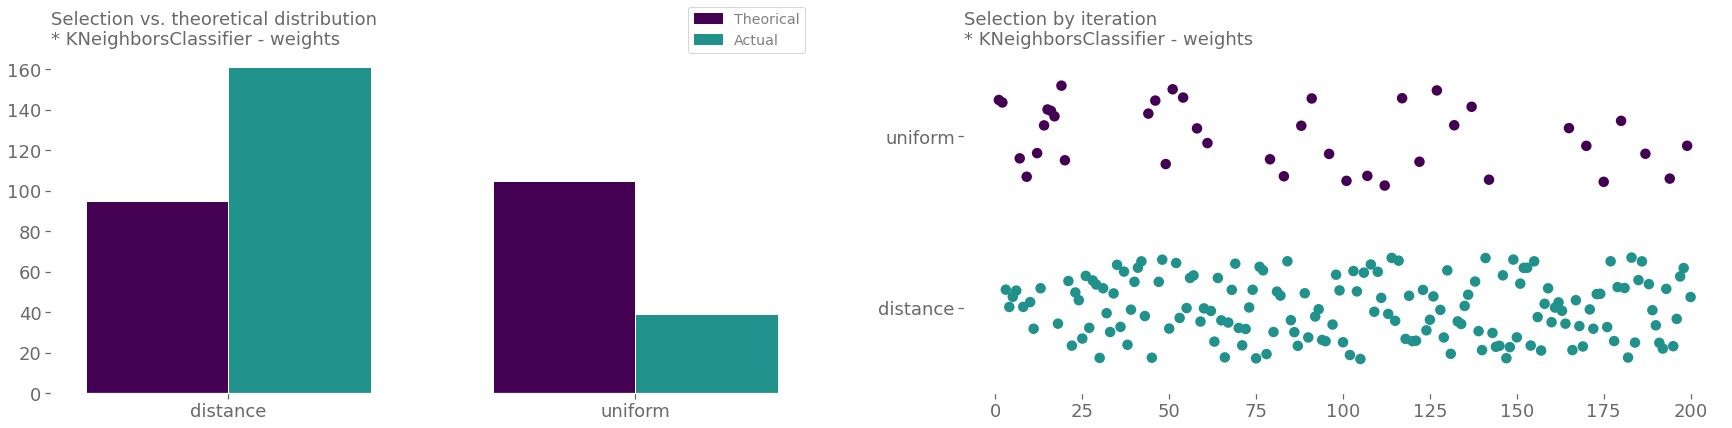

In [10]:
mlmachine_titanic_train.model_param_plot(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class="KNeighborsClassifier",
    estimator_parameter_space=estimator_parameter_space,
    n_iter=200,
)

In [11]:
# # pair-wise comparison
# p = PrettierPlot(chart_scale=20)
# p.pair_plot_custom(
#     df=mlmachine_titanic_train.unpack_bayes_optim_summary(bayes_optim_summary, "RandomForestClassifier"),
#     columns=["max_depth", "n_estimators","min_samples_split","iteration","iter_loss"],
#     gradient_col="iteration",
# #     color=style.style_grey
# )

In [12]:
top_models = mlmachine_titanic_train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

{'LogisticRegression': [30],
 'XGBClassifier': [61],
 'RandomForestClassifier': [46],
 'KNeighborsClassifier': [109]}

In [13]:
mlmachine_titanic_train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary,
    num_models=1,
)

{'LogisticRegression': [30],
 'XGBClassifier': [61],
 'RandomForestClassifier': [46],
 'KNeighborsClassifier': [109]}

In [14]:
# estimator_class = 'LogisticRegression'; model_iter = 176
estimator_class = 'XGBClassifier'; model_iter = 23
# estimator_class = 'RandomForestClassifier'; model_iter = 151
# estimator_class = 'KNeighborsClassifier'; model_iter = 466

model = mlmachine_titanic_train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class=estimator_class,
    model_iter=model_iter
)
print(model.custom_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.889389475984703,
              gamma=3.3780115677776656, learning_rate=0.12808132338914704,
              max_delta_step=0, max_depth=11,
              min_child_weight=8.069590253991297, missing=None,
              n_estimators=6356, n_jobs=4, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7790331095638126, verbosity=1)


In [15]:
model = mlmachine_titanic_train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class="RandomForestClassifier",
    model_iter=46
)
print(model.custom_model)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=4019,
                       n_jobs=4, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [16]:
# fit the model
model.fit(mlmachine_titanic_train.data, mlmachine_titanic_train.target)

# generate predictions
y_pred_train = model.predict(mlmachine_titanic_train.data)

# summarize results
training_accuracy = sum(y_pred_train == mlmachine_titanic_train.target) / len(y_pred_train)
print("RandomForestClassifier, iter = 46 \nTraining accuracy: {:.2%}".format(training_accuracy))

RandomForestClassifier, iter = 46 
Training accuracy: 94.16%
